In [1]:
import sys
import os
from typing import Tuple, Callable, List
from pathlib import Path
import random
from functools import partial
sys.path.insert(1, os.path.abspath('..') )

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PPO_Loss import *
from ActorCritic import ActorCritic
from ExperienceBuffer import PPOExperienceBuffer
from controllers import ppo
from tinyphysics_sim import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX


### Simulator

In [ ]:
def episode_rollout(model: TinyPhysicsModel, data_paths: List[str], buffer: PPOExperienceBuffer, policy_model: ActorCritic, n_episode: int, episode_len: int, path_boundary: float, device: torch.device):
    files = random.sample(data_paths, n_episode)
    controller = ppo.Controller(policy_model, device)
    sim = TinyPhysicsSimulator(model, files, controller=controller, episode_len=episode_len + 1)
    lat_cost, jerk_cost, total_cost = sim.rollout()

    # Calculate rewards
    deviation = np.abs(sim.target_lataccel_histories[:, CONTROL_START_IDX:] - sim.current_lataccel_histories[:, CONTROL_START_IDX:])
    rewards = 1 - deviation / path_boundary
    rewards[rewards < 0] = -1
    rewards = torch.from_numpy(rewards)
    if rewards.shape[1] != episode_len + 1:
        print(f"reward length doesn't match episode_len+1: rewards len:{len(rewards)}, episode_len+1:{episode_len+1}") 
        return

    buffer.reset()
    
    # Leave the value of last step for future reward estimation
    # Convert from list of episode_length of batch history to tensor of (batchsize, episode_len, ...)
    observation_history = torch.cat([x[:, None] for x in controller.observation_history[-episode_len-1: -1]], dim=1)
    target_history = torch.cat([x[:, None] for x in controller.target_history[-episode_len-1: -1]], dim=1)
    action_history = torch.column_stack(controller.action_history[-episode_len-1: -1])
    action_prob_history = torch.cat([x[:, None] for x in controller.action_prob_history[-episode_len-1: -1]], dim=1)
    value_history = torch.column_stack(controller.value_history[-episode_len-1:])

    buffer.batch_add_trajectory(observation_history,
                                target_history,
                                action_history,
                                action_prob_history,
                                rewards[:, :-1],
                                value_history)

    return buffer, rewards, lat_cost, jerk_cost, total_cost

### Training loop

In [ ]:
def train(policy_model: ActorCritic, optimizer: optim.Optimizer, run_rollout: Callable, episode_len: int, path_boundary: float, n_steps: int, n_episode: int, n_epoch: int, batch_size: int, clip_eps: float, c1: float, c2: float, device: torch.device):
    reward_history = []
    lat_cost_history = []
    jerk_cost_history = []

    total_loss_history = []
    actor_obj_history = []
    critic_loss_history = []
    entropy_obj_history = []

    for i_step in range(n_steps):
        # Run simulation
        buffer, rewards, lat_cost, jerk_cost, total_cost = run_rollout(policy_model, n_episode, episode_len, path_boundary, device)
        print(f'Training step {i_step:>3}: average_reward: {rewards.mean(): .4f}, lat_cost: {lat_cost: .2f}, jerk_cost: {jerk_cost: .2f}')
        # Record policy's performance at each step
        reward_history.append(rewards.mean().item())
        lat_cost_history.append(lat_cost)
        jerk_cost_history.append(jerk_cost)

        # Start training loops
        data_loader = DataLoader(buffer, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)
        policy_model.train()
        for i_epoch in range(n_epoch):
            print(f'Training step {i_step:>3}, epoch {i_epoch:>3}:', end='')

            epoch_total_loss_history = []
            epoch_actor_obj_history = []
            epoch_critic_loss_history = []
            epoch_entropy_obj_history = []

            for i_batch, data in enumerate(data_loader):
                actions, observations, targets, transitions = data
                actions = actions.type(torch.int)
                observations = observations.to(device)
                targets = targets.to(device)
                transitions = transitions.to(device)

                optimizer.zero_grad()

                action_prob_new, value_estimates = policy_model(observations, targets)
                action_prob_new = action_prob_new[torch.arange(actions.shape[0]), actions]
                value_estimates = value_estimates.flatten()

                loss, actor_obj, critic_loss, entropy_obj = ppo_loss(action_prob_new, transitions[:, 0], transitions[:, 3], value_estimates, transitions[:, 2], clip_eps, c1, c2)
                loss.backward()
                optimizer.step()

                epoch_total_loss_history.append(loss.item())
                epoch_actor_obj_history.append(actor_obj)
                epoch_critic_loss_history.append(critic_loss)
                epoch_entropy_obj_history.append(entropy_obj)

            total_loss_history.append(np.mean(epoch_total_loss_history))
            actor_obj_history.append(np.mean(epoch_actor_obj_history))
            critic_loss_history.append(np.mean(epoch_critic_loss_history))
            entropy_obj_history.append(np.mean(epoch_entropy_obj_history))

            print(f' total_loss: {total_loss_history[-1]: 0.3f}, actor_obj: {actor_obj_history[-1]: 0.3f}, critic_loss: {critic_loss_history[-1]: 0.3f}, entropy_obj: {entropy_obj_history[-1]: 0.3f}')
        
        if i_step % 10 == 9:
            torch.save({
                'step': i_step,
                'model_state_dict': policy_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'reward_history': reward_history,
                'lat_cost_history': lat_cost_history,
                'jerk_cost_history': jerk_cost_history,
                'total_loss_history': total_loss_history,
                'actor_obj_history': actor_obj_history,
                'critic_loss_history': critic_loss_history,
                'entropy_obj_history': entropy_obj_history
            }, f'./checkpoints/exp1_step{i_step + 1}.pt')

    return reward_history, lat_cost_history, jerk_cost_history, total_loss_history, actor_obj_history, critic_loss_history, entropy_obj_history

### Setup and hyperparameters

In [ ]:
device = torch.device('cuda')
tinyphysicsmodel = TinyPhysicsModel('../models/tinyphysics.onnx', debug=False)
policy_model = ActorCritic(obs_dim=3, obs_seq_len=10, target_dim=21, action_dim=ppo.ACTION_DIM, has_continuous_action=False).to(device)
data = Path('../data/')
data_paths = sorted(data.iterdir())[5000:]
data_paths = [str(x) for x in data_paths]
experience_buffer = PPOExperienceBuffer(discount_factor=0.94, td_decay=0.85)

n_episode = 256
episode_len = 300
path_boundary = 0.07

optimizer = optim.Adam(policy_model.parameters(), lr=1.5e-4, eps=1e-6)

batch_size = 1024
n_epoch = 3
n_step = 10

c1 = 0.5
c2 = 0.01
clip_eps = 0.1

sim_rollout = partial(episode_rollout, tinyphysicsmodel, data_paths, experience_buffer)

In [2]:
df = pd.read_csv('../data/00110.csv')
device = torch.device('cpu')
tinyphysicsmodel = TinyPhysicsModel('../models/tinyphysics.onnx', debug=False)
policy_model = ActorCritic(obs_dim=4, obs_seq_len=10, target_dim=31, action_dim=1, has_continuous_action=True, action_scale=2).to(device)
# policy_params = torch.load('checkpoints/exp0827-2_step2990.pt')['model_state_dict']
# policy_model.load_state_dict(policy_params)
controller = ppo.Controller(policy_model, device, eval=True)
sim = TinyPhysicsSimulator(tinyphysicsmodel, [df], controller=controller, episode_len=450)
lat_cost, jerk_cost, total_cost = sim.rollout()

/home/risak/controls_challenge/venv/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


In [9]:
list(policy_model.feature_lstm.parameters()) + list(policy_model.actor.parameters()) + [policy_model.log_std]

[Parameter containing:
 tensor([[-0.0725, -0.0496,  0.2418, -0.0416],
         [-0.0135,  0.2295, -0.0379, -0.0663],
         [-0.2149,  0.1388,  0.1775,  0.0744],
         [-0.0646, -0.1002,  0.1215,  0.2086],
         [ 0.1228, -0.0074,  0.2423,  0.0172],
         [-0.2473, -0.0660, -0.1407, -0.0241],
         [-0.0101, -0.2053,  0.1138, -0.1785],
         [-0.0196,  0.2122, -0.1046, -0.2443],
         [-0.1013, -0.1059,  0.0888,  0.0879],
         [-0.0282, -0.0387, -0.1075,  0.0965],
         [-0.1154,  0.1285, -0.1212, -0.0087],
         [-0.0482,  0.0672, -0.0228,  0.0270],
         [-0.0911,  0.1298,  0.1523, -0.2137],
         [ 0.1638,  0.1374,  0.2207,  0.2080],
         [ 0.1098, -0.0045, -0.2447, -0.1757],
         [ 0.1645, -0.2278, -0.2081, -0.0976],
         [-0.0547,  0.2424, -0.1828,  0.1883],
         [ 0.0025, -0.0223, -0.0657, -0.1231],
         [ 0.1057,  0.0281, -0.1301,  0.2284],
         [ 0.1187,  0.2006, -0.2448,  0.2332],
         [-0.1825,  0.0514, -0.0649, 

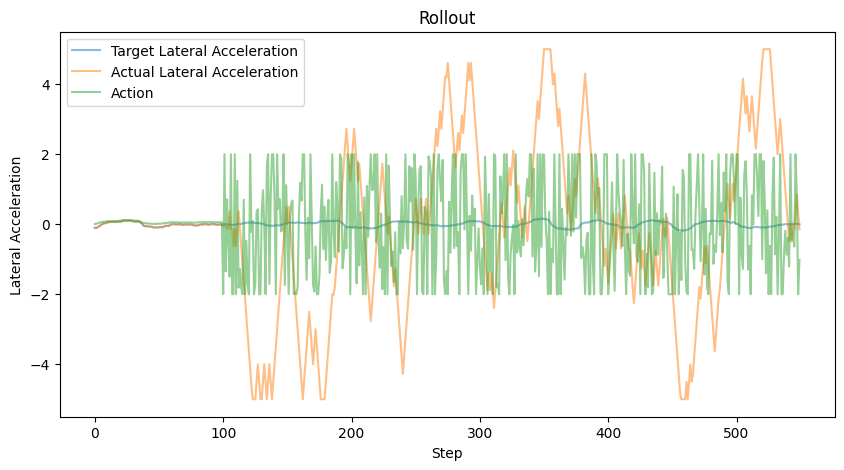

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sim.target_lataccel_histories.flatten(), label="Target Lateral Acceleration", alpha=0.5)
ax.plot(sim.current_lataccel_histories.flatten(), label="Actual Lateral Acceleration", alpha=0.5)
ax.plot(sim.action_histories.flatten(), label="Action", alpha=0.5)
# ax.plot([x[2] for x in sim.state_history], label="aEgo", alpha=0.5)

ax.legend()
ax.set_xlabel("Step")
ax.set_ylabel("Lateral Acceleration")
ax.set_title("Rollout")
plt.show()

In [ ]:
total_cost

In [ ]:
sim.get_future_plan(392).shape

In [ ]:
np.save('results/result1.npy', np.array(result, dtype=object), allow_pickle=True)

In [ ]:
np.load('results/result1.npy', allow_pickle=True)